# Previsão de Preço do Bitcoin com RNN, LSTM e GRU (PyTorch)

Este notebook mostra um fluxo completo para prever a série temporal de preços do **BTC** usando três arquiteturas recorrentes clássicas:

1. **RNN simples**
2. **LSTM**
3. **GRU**

No final, vamos **comparar o desempenho** das três técnicas sobre o mesmo conjunto de validação.


In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Carregando e preparando os dados

O primeiro passo é carregar nossos dados.

1.  Tentamos carregar um arquivo CSV local (`btc_price.csv`). Se não for encontrado, geramos uma série sintética apenas para fins de demonstração.
2.  Usamos apenas a coluna de preço (`Close`).
3.  **Normalização:** Redes neurais convergem muito mais rápido e de forma mais estável quando os dados de entrada estão em uma escala pequena. Usamos `MinMaxScaler` do Scikit-learn para reescalar todos os preços para o intervalo `[0, 1]`. O `scaler` será guardado para reverter a normalização no ## 1. Carregando e preparando os dados

O primeiro passo é carregar nossos dados.

1.  Tentamos carregar um arquivo CSV local (`btc_price.csv`). Se não for encontrado, geramos uma série sintética apenas para fins de demonstração.
2.  Usamos apenas a coluna de preço (`Close`).
3.  **Normalização:** Redes neurais convergem muito mais rápido e de forma mais estável quando os dados de entrada estão em uma escala pequena. Usamos `MinMaxScaler` do Scikit-learn para reescalar todos os preços para o intervalo `[0, 1]`. O `scaler` será guardado para reverter a normalização no final.final.

Usando dados de ../datasets/btc_price.csv com 1000 pontos.


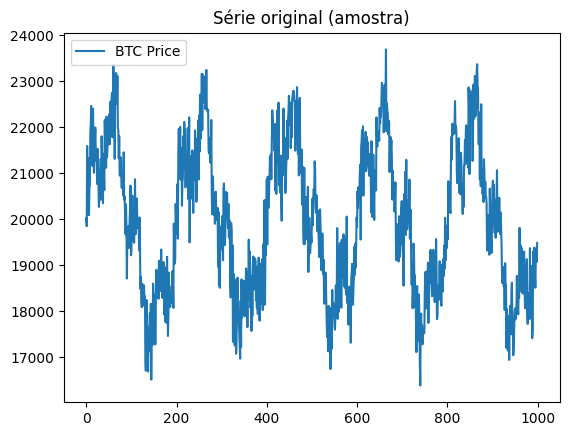

In [2]:
# Tenta carregar dados reais
csv_path = "../datasets/btc_price.csv"

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    # tenta detectar nome de coluna
    possible_cols = ["close", "Close", "Adj Close", "adj_close"]
    close_col = None
    for c in possible_cols:
        if c in df.columns:
            close_col = c
            break
    if close_col is None:
        raise ValueError("Não encontrei coluna de preço no CSV. Use 'close' ou 'Close'.")
    prices = df[close_col].values.reshape(-1, 1).astype(np.float32)
    print(f"Usando dados de {csv_path} com {len(prices)} pontos.")
else:
    # gera série sintética (substitua pelos dados reais)
    timesteps = 1200
    t = np.arange(timesteps)
    prices = (20000 + 2000*np.sin(2*np.pi*t/200) + 800*np.sin(2*np.pi*t/50) + 500*np.random.randn(timesteps)).astype(np.float32)
    prices = prices.reshape(-1, 1)
    print("Arquivo btc_price.csv não encontrado. Gerando série sintética para demonstração.")

# normalização
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

plt.plot(prices, label="BTC Price")
plt.title("Série original (amostra)")
plt.legend()
plt.show()

## 2. Criando janelas de tempo (supervisionado)

Modelos de série temporal precisam ser "enquadrados" (framed) como um problema de aprendizado supervisionado.

-   **Problema:** Prever o preço de amanhã.
-   **Solução:** Usar os últimos `N` dias (nossa `SEQ_LEN`) como *features* (X) para prever o preço do dia `N+1` como *label* (y).

Usaremos uma janela deslizante (sliding window) para criar esses pares (X, y) a partir da nossa série temporal.

-   `X` terá o shape: `(N_amostras, 30, 1)` (30 dias de sequência, 1 feature por dia)
-   `y` terá o shape: `(N_amostras, 1)` (o preço do 31º dia)

Finalmente, dividimos os dados em 80% para treino e 20% para validação.

In [3]:
def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 30
X, y = create_sequences(prices_scaled, SEQ_LEN)
print("Shape X:", X.shape, "Shape y:", y.shape)

# split treino/val
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)

Shape X: (970, 30, 1) Shape y: (970, 1)
Train: (776, 30, 1) (776, 1)
Val: (194, 30, 1) (194, 1)


### DataLoader do PyTorch

Para alimentar os dados na rede de forma eficiente (em lotes, ou *batches*), usamos as classes `Dataset` e `DataLoader` do PyTorch.

-   `SequenceDataset`: Uma classe customizada que armazena nossos tensores X e y.
-   `DataLoader`: Envolve o `Dataset` e nos fornece um iterador que gera *batches* de dados (ex: 64 sequências por vez) e os embaralha (`shuffle=True`) durante o treino.

In [4]:
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SequenceDataset(X_train, y_train)
val_ds = SequenceDataset(X_val, y_val)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

## 3. Definindo os modelos (RNN, LSTM, GRU)

Definimos as três arquiteturas que vamos comparar. Todas elas compartilham uma estrutura similar:

1.  Uma **camada recorrente** (RNN, LSTM ou GRU) que processa a sequência de 30 dias.
2.  Uma **camada linear** (`fc`) que pega a saída do último *time step* da camada recorrente e a mapeia para uma única previsão de saída (o preço do dia seguinte).

---
### RNN (Simple)
A Rede Neural Recorrente mais simples. Ela possui um "estado oculto" (`hidden_state`) que é atualizado a cada passo de tempo, mas sofre do problema de "vanishing gradients" (gradientes que desaparecem), tornando difícil aprender dependências de longo prazo.

### LSTM (Long Short-Term Memory)
Projetada para resolver o problema da RNN. A LSTM usa um **estado de célula** (`cell_state`) separado e três "portões" (*gates*) para controlar o fluxo de informação:
-   **Forget Gate:** Decide o que esquecer do estado de célula anterior.
-   **Input Gate:** Decide o que adicionar ao novo estado de célula.
-   **Output Gate:** Decide o que emitir como estado oculto (a previsão).

### GRU (Gated Recurrent Unit)
Uma versão simplificada da LSTM. Ela combina os *gates* de *forget* e *input* em um único "Update Gate" e possui um "Reset Gate". A GRU geralmente tem desempenho similar à LSTM, mas é computacionalmente mais rápida por ter menos parâmetros.

In [5]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

rnn_model = RNNModel().to(DEVICE)
lstm_model = LSTMModel().to(DEVICE)
gru_model = GRUModel().to(DEVICE)

rnn_model, lstm_model, gru_model

(RNNModel(
   (rnn): RNN(1, 64, batch_first=True)
   (fc): Linear(in_features=64, out_features=1, bias=True)
 ),
 LSTMModel(
   (lstm): LSTM(1, 64, batch_first=True)
   (fc): Linear(in_features=64, out_features=1, bias=True)
 ),
 GRUModel(
   (gru): GRU(1, 64, batch_first=True)
   (fc): Linear(in_features=64, out_features=1, bias=True)
 ))

## 4. Funções de treino e avaliação

Criamos duas funções de *loop* genéricas para treinar e avaliar qualquer um dos modelos que definimos.

-   `train_one_epoch`: Executa o *loop* de treinamento padrão (forward pass, cálculo da loss, backpropagation, otimização).
-   `evaluate`: Executa o *loop* de validação (sempre usando `model.eval()` e `torch.no_grad()` para desativar o cálculo de gradientes e o dropout).

In [6]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    preds_all = []
    y_all = []
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        total_loss += loss.item() * X_batch.size(0)
        preds_all.append(preds.cpu().numpy())
        y_all.append(y_batch.cpu().numpy())
    preds_all = np.concatenate(preds_all)
    y_all = np.concatenate(y_all)
    return total_loss / len(loader.dataset), preds_all, y_all

## 5. Treinando RNN, LSTM e GRU

Agora, vamos instanciar e treinar cada modelo.

-   **Critério (Loss Function):** Usamos `nn.MSELoss()` (Mean Squared Error - Erro Quadrático Médio), que é a função de perda padrão para problemas de regressão.
-   **Otimizador:** Usamos `Adam`, um otimizador eficiente e popular.
-   **Histórico:** Armazenamos os *losses* de treino e validação de cada época para plotagem posterior.

In [7]:
EPOCHS = 15  # aumente se quiser
criterion = nn.MSELoss()

models = {
    "RNN": rnn_model,
    "LSTM": lstm_model,
    "GRU": gru_model
}

histories = {}

for name, model in models.items():
    print(f"\n=== Treinando {name} ===")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses = []
    val_losses = []
    for epoch in range(1, EPOCHS+1):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, _, _ = evaluate(model, val_loader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{name} | Epoch {epoch}/{EPOCHS} | train={train_loss:.5f} | val={val_loss:.5f}")
    histories[name] = {"train": train_losses, "val": val_losses}


=== Treinando RNN ===
RNN | Epoch 1/15 | train=0.22612 | val=0.04441
RNN | Epoch 2/15 | train=0.04778 | val=0.04035
RNN | Epoch 3/15 | train=0.03389 | val=0.03104
RNN | Epoch 4/15 | train=0.02807 | val=0.02623
RNN | Epoch 5/15 | train=0.02301 | val=0.02049
RNN | Epoch 6/15 | train=0.01416 | val=0.00878
RNN | Epoch 7/15 | train=0.00897 | val=0.00772
RNN | Epoch 8/15 | train=0.00819 | val=0.00759
RNN | Epoch 9/15 | train=0.00760 | val=0.00715
RNN | Epoch 10/15 | train=0.00738 | val=0.00695
RNN | Epoch 11/15 | train=0.00705 | val=0.00701
RNN | Epoch 12/15 | train=0.00747 | val=0.00677
RNN | Epoch 13/15 | train=0.00716 | val=0.00676
RNN | Epoch 14/15 | train=0.00694 | val=0.00670
RNN | Epoch 15/15 | train=0.00730 | val=0.00704

=== Treinando LSTM ===
LSTM | Epoch 1/15 | train=0.15459 | val=0.06615
LSTM | Epoch 2/15 | train=0.05237 | val=0.03924
LSTM | Epoch 3/15 | train=0.03907 | val=0.03862
LSTM | Epoch 4/15 | train=0.03333 | val=0.03122
LSTM | Epoch 5/15 | train=0.02744 | val=0.02376
LS

## 6. Curvas de perda

Plotar o *loss* de validação (MSE) ao longo das épocas nos ajuda a visualizar como cada modelo aprendeu.

Idealmente, queremos ver o *loss* cair rapidamente e estabilizar (convergir). Isso também nos dá uma primeira indicação de qual modelo está se saindo melhor (linha mais baixa no gráfico).

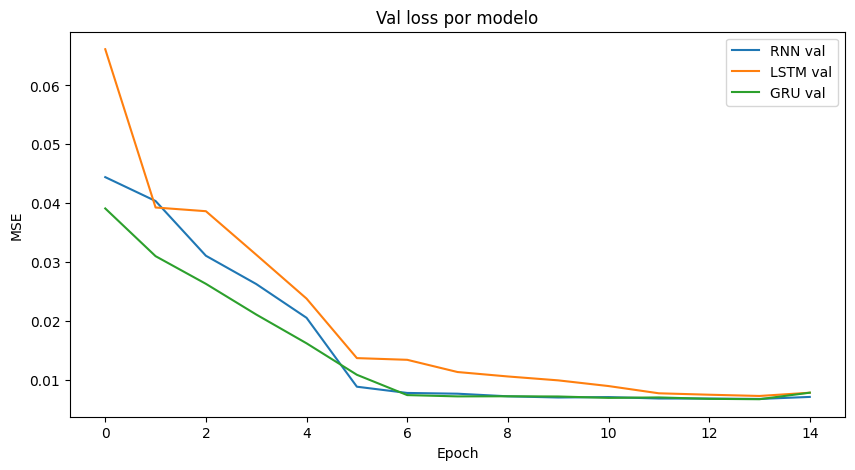

In [8]:
plt.figure(figsize=(10,5))
for name, h in histories.items():
    plt.plot(h["val"], label=f"{name} val")
plt.title("Val loss por modelo")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

## 7. Comparação final (mesmo conjunto de validação)

O MSE (loss) é ótimo para o treinamento, mas não é intuitivo para interpretação, pois está no domínio *escalonado* (0-1).

Para uma comparação justa, faremos o seguinte:
1.  Rodar a avaliação final em todos os modelos.
2.  **Desnormalizar** as previsões (`preds`) e os valores reais (`y_true`) usando `scaler.inverse_transform()`. Isso converte os valores de volta para Dólares (USD).
3.  Calcular duas métricas interpretáveis:
    -   **MAE (Mean Absolute Error):** O erro médio em dólares. (Ex: "O modelo errou a previsão em média por $500").
    -   **RMSE (Root Mean Squared Error):** A raiz do MSE, também em dólares. Ele penaliza erros maiores mais fortemente que o MAE.

In [9]:
criterion = nn.MSELoss()
results = {}

for name, model in models.items():
    val_loss, preds_scaled, y_scaled = evaluate(model, val_loader, criterion)
    # desnormalizar
    preds = scaler.inverse_transform(preds_scaled)
    y_true = scaler.inverse_transform(y_scaled)
    mae = np.mean(np.abs(preds - y_true))
    rmse = np.sqrt(np.mean((preds - y_true)**2))
    results[name] = {"val_mse": val_loss, "mae": mae, "rmse": rmse}

results_df = pd.DataFrame(results).T
results_df

,val_mse,mae,rmse
RNN,0.007042,495.162811,612.460815
LSTM,0.007756,511.573059,642.749023
GRU,0.007763,529.104004,643.053894


## 8. Visualização das previsões (melhor modelo)

Por fim, selecionamos o modelo com o menor RMSE (melhor desempenho geral) e plotamos suas previsões (em dólar) contra os preços reais (em dólar) do conjunto de validação.

Isso nos dá a melhor visualização de como o modelo está capturando as tendências e a volatilidade do mercado no período que ele não viu durante o treino.

Melhor modelo: RNN


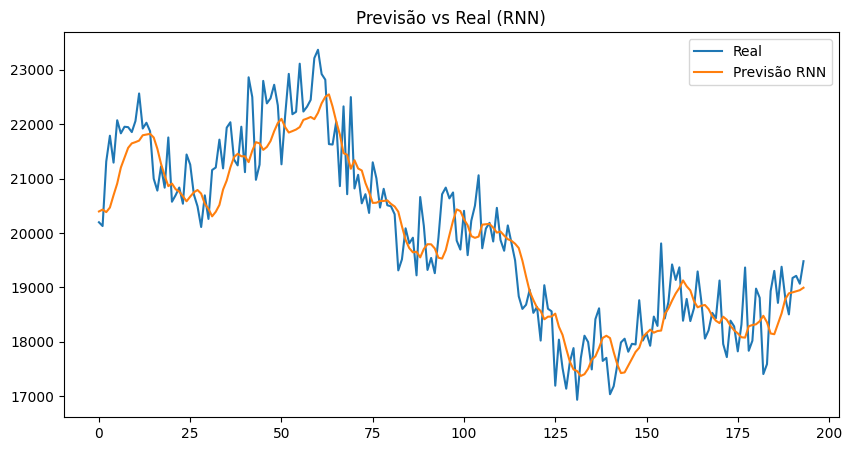

In [10]:
# escolher o melhor modelo por RMSE
best_name = min(results.items(), key=lambda x: x[1]["rmse"])[0]
print("Melhor modelo:", best_name)
best_model = models[best_name]

_, preds_scaled, y_scaled = evaluate(best_model, val_loader, nn.MSELoss())
preds = scaler.inverse_transform(preds_scaled)
y_true = scaler.inverse_transform(y_scaled)

plt.figure(figsize=(10,5))
plt.plot(y_true, label="Real")
plt.plot(preds, label=f"Previsão {best_name}")
plt.title(f"Previsão vs Real ({best_name})")
plt.legend()
plt.show()